In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import os
import numpy as np
import pandas as pd
# local import
from utils import read_mi

In [3]:
GENOME_LEN = 29903

In [4]:
gene_colors = {
'ORF1ab': '#8dd3c7',
'S': '#ffffb3',
'ORF3a': '#bebada',
'E': '#fb8072',
'M': '#80b1d3',
'ORF6': '#fdb462',
'ORF7a': '#b3de69',
'ORF7b': '#fccde5',
'ORF8': '#d9d9d9',
'N': '#bc80bd',
'ORF10': '#ccebc5'
}

In [5]:
df = []
for name in os.listdir('../out/time-filtered-subsets/'):
    try:
        df.append(read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated.tsv.gz',
                          name,
                          date=True))
    except FileNotFoundError:
        pass
df = pd.concat(df)

In [6]:
cols = ['pos_source', 'pos_target', 'distance', 'mi',
        'gene_source', 'gene_target',
        'feature_codon_source', 'feature_codon_target']

In [7]:
ag = df[(~df['gene_source'].isna()) & (~df['gene_target'].isna())].copy()

In [8]:
icount = ag.groupby(['name', 'interaction'])['pos_source'].count()
# icount.name = 'proportion'
icount = icount.reset_index().dropna()
icount

,name,interaction,pos_source
0,2020-03,different gene,1842
1,2020-03,same gene,76944
2,2020-04,different gene,23968
3,2020-04,same gene,47984
4,2020-05,different gene,20498
...,...,...,...
69,2023-01,same gene,398
70,2023-02,different gene,152
71,2023-02,same gene,406
72,2023-03,different gene,168


In [9]:
icount.sort_values('pos_source')

,name,interaction,pos_source
52,2022-05,different gene,102
54,2022-06,different gene,108
50,2022-04,different gene,116
58,2022-08,different gene,120
56,2022-07,different gene,122
...,...,...,...
9,2020-07,same gene,36200
5,2020-05,same gene,43674
3,2020-04,same gene,47984
7,2020-06,same gene,49094


In [10]:
icount[icount['interaction'] == 'different gene'].sort_values('name').tail(12)['pos_source'].median()

137.0

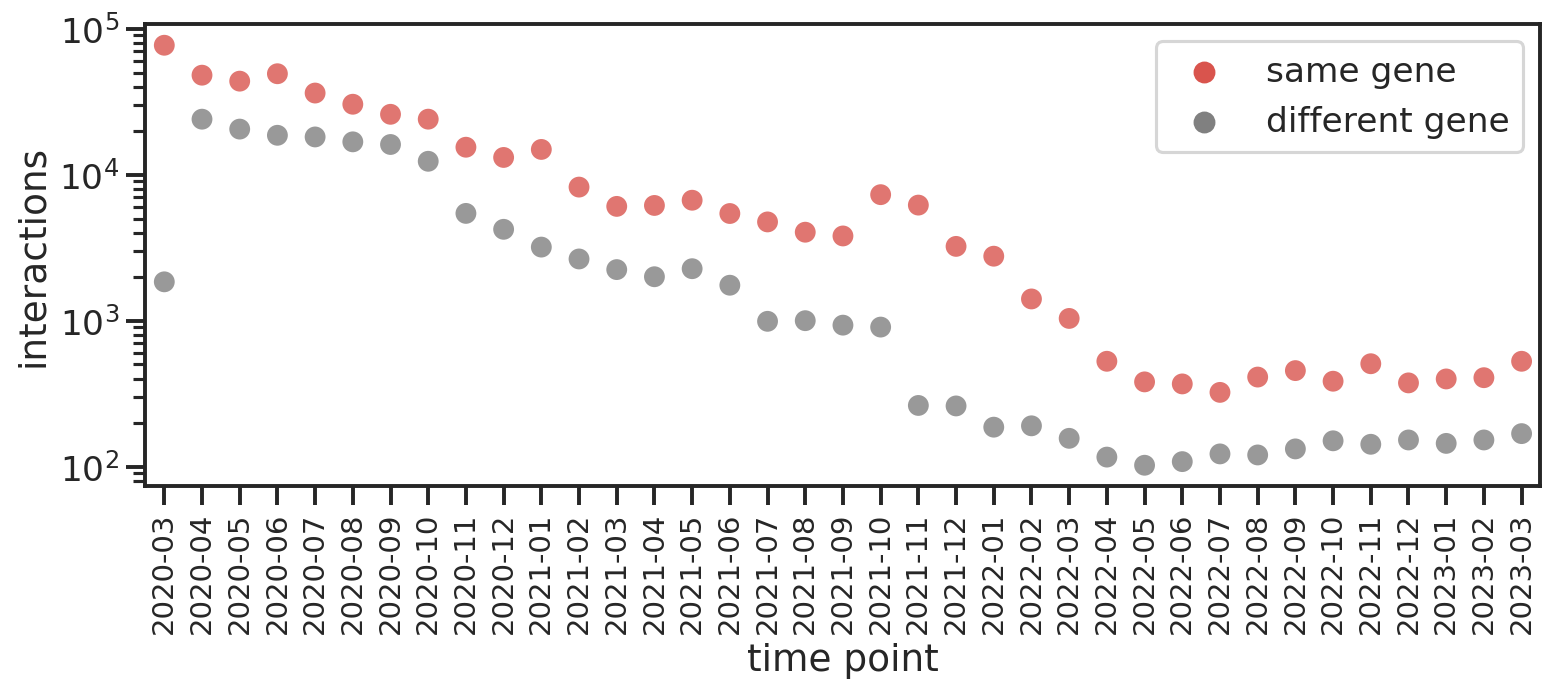

In [11]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=icount,
              y='pos_source',
              x='name',
              hue='interaction',
              size=10,
              jitter=0,
              alpha=0.8,
              hue_order=['same gene',
                         'different gene'],
              palette=['xkcd:pale red',
                       'grey'])

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',)

plt.ylabel('interactions')
plt.xlabel('time point')

plt.yscale('log')

plt.savefig('inter_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('inter_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [12]:
inter = df[
          # (df['outlier'] == 4) &
          (df['gene_source'] == 'S') &
          (df['interaction'] == 'different gene')
         ].sort_values(['name', 'mi'], ascending=False)[['name', 'outlier'] + cols].dropna()

In [13]:
s = inter.pivot_table(index=['gene_source', 'gene_target',
                                  'feature_codon_source',
                                  'feature_codon_target', 'pos_source', 'pos_target'],
                           columns='name',
                           values='outlier')
s = s.reindex(columns=sorted(df['name'].unique()))
s[s<4] = np.nan
s[s>3] = 1
idx = s.T.sum()[s.T.sum() > 8].index
s = inter.pivot_table(index=['gene_source', 'gene_target',
                                  'feature_codon_source',
                                  'feature_codon_target', 'pos_source', 'pos_target'],
                           columns='name',
                           values='outlier')
s = s.reindex(columns=sorted(df['name'].unique())).loc[idx]

In [14]:
s = s.reset_index().set_index('gene_target').reset_index().set_index(['gene_source', 'gene_target',
                                   'feature_codon_source',
                                   'feature_codon_target', 'pos_source', 'pos_target'])

In [15]:
# ugly hack
res = []
s = s.reset_index()
for gene in [
             'ORF1ab',
             'ORF3a',
             # 'E',
             'M',
             # 'ORF6',
             # 'ORF7a', 'ORF7b', 'ORF8',
             'N']:
    t = s[s['gene_target'] == gene].sort_values(['feature_codon_source',
                                                 'feature_codon_target'])
    res.append(t)
s = pd.concat(res).set_index(['gene_source', 'gene_target',
                              'feature_codon_source',
                              'feature_codon_target',
                              'pos_source', 'pos_target'])

In [16]:
s.shape

(7, 37)

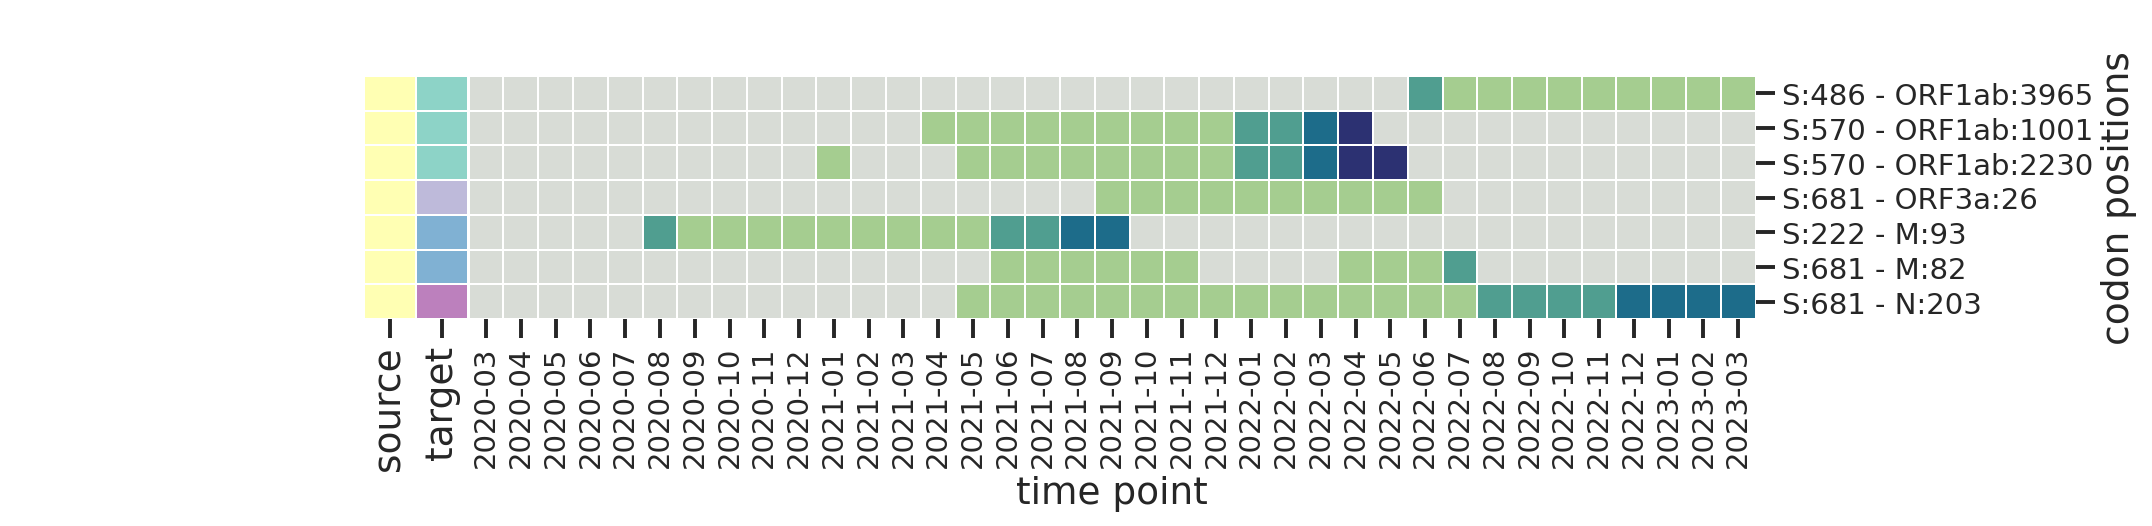

In [17]:
cmap = plt.get_cmap('crest_r').copy()
cmap.set_bad('xkcd:light grey')

colors1 = []
colors2 = []
for g1, g2, _, _, _, _ in s.index:
    colors1.append(gene_colors[g1])
    colors2.append(gene_colors[g2])

cm = sns.clustermap(s,
                    cmap=cmap,
                    row_cluster=False, col_cluster=False,
                    row_colors=pd.DataFrame([[a, b] for a, b in zip(colors1, colors2)],
                                            columns=['source', 'target'],
                                            index=s.index),
                    linewidths=0.005,
                    cbar_pos=None,
                    figsize=(17, 4),
                    vmin=1, vmax=4)

cm.ax_heatmap.set_xlabel('time point')
cm.ax_heatmap.set_ylabel('codon positions')

cm.ax_heatmap.set_xticks([x + 0.5 for x in range(s.shape[1])],
                         s.columns,
                         fontsize=14)
cm.ax_heatmap.set_yticks([x + 0.5 for x in range(s.shape[0])],
                         [f'{g1}:{int(x)} - {g2}:{int(y)}' for g1, g2, x, y, _, _ in s.index],
                         fontsize=14)

cm.ax_row_colors.set_xticks([0.5, 1.5],
                            ['source', 'target'],
                            fontsize=18)

plt.savefig('inter_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('inter_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);
pass

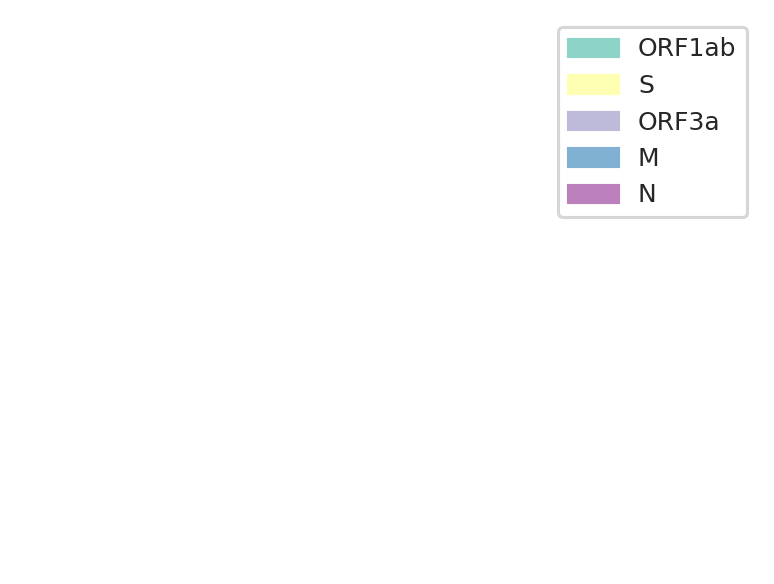

In [18]:
patches = []
for k, v in gene_colors.items():
    if k not in {x[1] for x in s.index}.union(['S']):
        continue
    patch = mpatches.Patch(color=v, label=k)
    patches.append(patch)

plt.legend(handles=patches, facecolor='w', fontsize=12, ncols=1)

plt.xticks([])
plt.yticks([])

sns.despine(left=True, bottom=True)

plt.savefig('inter_2_legend.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('inter_2_legend.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [19]:
s_muts = {int(y) for x, _, _, _, y, _ in s.index}
o_muts = {int(y) for _, x, _, _, _, y in s.index}

d_s_muts = {int(y): f'{x}:{int(z)}:{int(y)}' for x, _, z, _, y, _ in s.index}
d_o_muts = {int(y): f'{x}:{int(z)}:{int(y)}' for _, x, _, z, _, y in s.index}

d_muts = {**d_s_muts, **d_o_muts}

In [20]:
res = []
for f in os.listdir('../out/time-lineages/'):
    l = pd.read_csv(f'../out/time-lineages/{f}', sep='\t',
                    usecols=['seqName', 'clade', 'Nextclade_pango',
                             'partiallyAliased', 'clade_nextstrain',
                             'clade_who', 'clade_display',
                             'substitutions', 'deletions', 'insertions',
                             'aaSubstitutions', 'aaDeletions', 'aaInsertions'])
    date = f.split('.')[0]
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])

    if date == '2020-02':
        continue

    for kind in ['substitutions', 'deletions', 'insertions']:
        for clade, line in l[['clade_display', kind]].values:
            if type(line) == float:
                continue
            for x in line.split(','):
                if '-' in x:
                    for v in range(int(x.split('-')[0]),
                                   int(x.split('-')[1]) + 1):
                        if v not in s_muts and v not in o_muts:
                            continue
                        res.append((date, clade, kind, v, d_muts[v]))
                else:
                    try:
                        v = int(x.split(':')[0])
                    except ValueError:
                        v = x
                        while True:
                            if len(v) == 0:
                                v = 0
                                print(x)
                                break
                            v = v[1:]
                            try:
                                v = int(v)
                            except ValueError:
                                v = v[:-1]
                                try:
                                    v = int(v)
                                except ValueError:
                                    continue
                            break
                    if v in d_muts:
                        res.append((date, clade, kind, v, d_muts[v]))

In [21]:
r = pd.DataFrame(res,
                 columns=['name', 'clade', 'kind', 'position', 'fingerprint'])

In [22]:
t = r.groupby(['name', 'position', 'fingerprint'])['clade'].count().reset_index()
t['proportion'] = t['clade'] / 2500

In [23]:
t['fingerprint'].unique()

array(['S:570:23271', 'S:681:23604', 'ORF3a:26:25469', 'M:93:26801',
       'N:203:28881', 'S:222:22227', 'ORF1ab:1001:3267',
       'ORF1ab:3965:12160', 'M:82:26767', 'ORF1ab:2230:6954',
       'S:486:23018'], dtype=object)

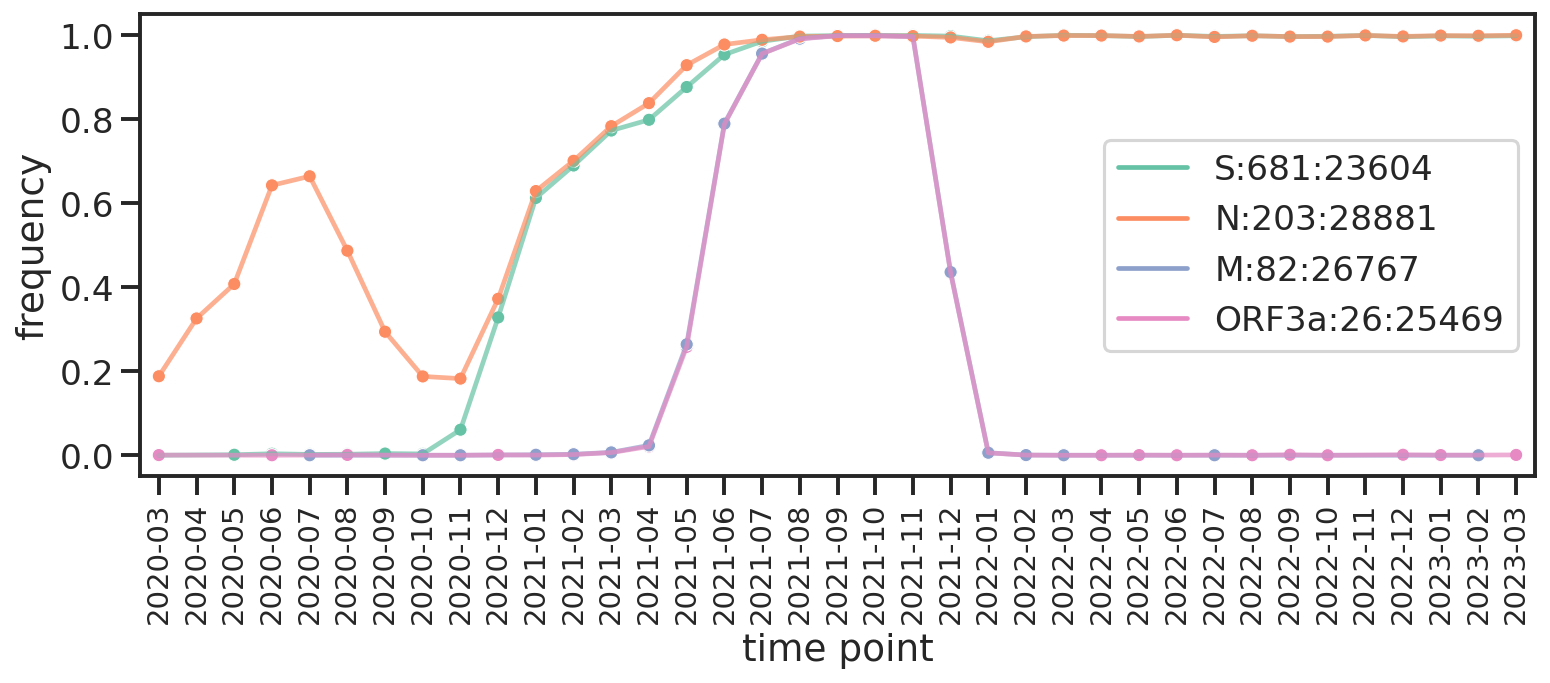

In [24]:
plt.figure(figsize=(12, 4))

sns.lineplot(data=t[t['fingerprint'].isin(['S:681:23604', 'N:203:28881', 'M:82:26767', 'ORF3a:26:25469'])],
             x='name', y='proportion',
             hue ='fingerprint',
             hue_order=['S:681:23604', 'N:203:28881', 'M:82:26767', 'ORF3a:26:25469'],
             palette='Set2',
             alpha=0.7)
sns.scatterplot(data=t[t['fingerprint'].isin(['S:681:23604', 'N:203:28881', 'M:82:26767', 'ORF3a:26:25469'])],
             x='name', y='proportion',
             hue ='fingerprint',
             hue_order=['S:681:23604', 'N:203:28881', 'M:82:26767', 'ORF3a:26:25469'],
             palette='Set2',
             size=10,
             legend=None)

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',)

plt.ylabel('frequency')
plt.xlabel('time point')

plt.xlim(-0.5, len(t['name'].unique()) - 0.5)

plt.savefig('inter_3.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('inter_3.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);